## 1. Benchmark Dataset: 
타이타닉 호에서 탑승했던 사람들의 정보를 바탕으로 생존 여부를 예측
하는 문제입니다. 과제에서 제시한 머신러닝 모델들을 이용하여 각 모델의 성능을 평가해야
합니다. 데이터는 다음 주소에서 얻을 수 있습니다: https://www.kaggle.com/c/titanic
이번 과제에서는 모델 학습 및 테스트 모두 train.csv파일을 이용합니다.
과제를 수행하실 때 다음의 feature들은 모델 학습에 이용하지 않도록 주의해주세요.
제외할 feature: PassengerId, Name, Ticket, Cabin

## 2. Preprocessing
    1) train data에 결측치(NULL)가 있는 feature들이 있습니다. 이 값들을 어떻게 처리할 것인지 아이디어를 제시하고 실제로 구현하세요. 
    2) One-Hot encoding을 수행할 필요가 있는 feature들이 무엇이며 그 이유는 무엇인지 서술하세요. 또한 실제로 어떻게 구현했는지 보고서에 나타내세요.
    3) train.csv의 sample을 7대 3으로 학습 데이터와 테스트 데이터로 사용하세요.
    4) 그 외 진행한 전처리 과정이 있다면 서술하세요

https://dlearner.tistory.com/22

In [913]:
import pandas as pd
import numpy as np


In [914]:
whole_df = pd.read_csv("train.csv")
whole_df.shape

(892, 12)

891은 column 이름 제외한 수

In [915]:
print(891 * (2/3))
print(891 * (1/3))

594.0
297.0


In [916]:
train_df = pd.read_csv("train.csv", nrows=594)
test_df = pd.read_csv('train.csv', skiprows=595)
combine=[train_df, test_df]
train_df.shape, test_df.shape

((594, 12), (297, 12))

In [917]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
589,590,0,3,"Murdlin, Mr. Joseph",male,NaN,0,0,A./5. 3235,8.0500,NaN,S
590,591,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S
591,592,1,1,"Stephenson, Mrs. Walter Bertram (Martha Eustis)",female,52.0,1,0,36947,78.2667,D20,C
592,593,0,3,"Elsbury, Mr. William James",male,47.0,0,0,A/5 3902,7.2500,NaN,S
593,594,0,3,"Bourke, Miss. Mary",female,NaN,0,2,364848,7.7500,NaN,Q


In [918]:
test_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,595,0,2,"Chapman, Mr. John Henry",male,37.0,1,0,SC/AH 29037,26.000,NaN,S
1,596,0,3,"Van Impe, Mr. Jean Baptiste",male,36.0,1,1,345773,24.150,NaN,S
2,597,1,2,"Leitch, Miss. Jessie Wills",female,NaN,0,0,248727,33.000,NaN,S
3,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.000,NaN,S
4,599,0,3,"Boulos, Mr. Hanna",male,NaN,0,0,2664,7.225,NaN,C


In [919]:
import graphviz

잘 안 될 경우 관리자 권한으로 anaconda prompt열어서 conda install python-graphviz이나 pip install graphviz 등등 시도

In [920]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

In [921]:
# 모델 등등
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict

#### 1 제외 할 feature: PassengerId, Name, Ticket, Cabin

In [922]:
train_df = train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
combine=[train_df, test_df]

In [923]:
print(train_df.columns.values)

['Survived' 'Pclass' 'Sex' 'Age' 'SibSp' 'Parch' 'Fare' 'Embarked']


#### 2-1) train data에 결측치(NULL)가 있는 feature들이 있습니다. 이 값들을 어떻게 처리할 것인지 아이디어를 제시하고 실제로 구현하세요.
<br>  -> 'Age' column에선 다수의, 'Embarked' column에선 극소수의 샘플에 대해 NULL값이 있음. 
<br>  a) 'Embarked'는 (눈으로 세어보니 2개) 워낙 갯수도 적고, 생존 여부에 영향을 주는 attribute이면서도 평균이나 중간값 등으로 처리하기 애매하므로 그냥 해당 sample은 drop할 생각. 하지만 지금 drop해버리면 pre-processing의 과정이 번거로워지므로 현재는 None 문자열로 잠깐 바꿔 두었다가 2-4) 파트에서 drop 예정
<br>
<br>  b) 'Age'에 column에서 나오는 NULL 갯수는 무시할 수 없을 만큼 많은데, 그렇다고 전부 다 평균이나 중간값으로 대체하는 것은 실제 데이터(기록되진 않았지만 그 사람의 실제 나이)와는 괴리가 너무 커질 것으로 예상. 따라서 NULL값은 최빈값처럼 취급하고자, csv 파일을 살펴본 결과 가장 다수를 차지하는 20~30대의 범주로 포함시키기 위해 28로 설정


In [924]:
train_df['Embarked']= train_df['Embarked'].replace(np.NaN,"None")
test_df['Embarked'] = test_df['Embarked'].replace(np.NaN,"None")

train_df['Age'] = train_df['Age'].replace(np.NaN, 28)
test_df['Age'] = test_df['Age'].replace(np.NaN, 28)

combine=[train_df, test_df]

#### 2-2) One-Hot encoding을 수행할 필요가 있는 feature들이 무엇이며 그 이유는 무엇인지 서술하세요. 또한 실제로 어떻게 구현했는지 보고서에 나타내세요.
-> scikit-learn을 사용할 때 문자열로 나타나는 feature들은 Label이든 One-Hot이든 숫자로 encoding해 줘야 함. 그 중에서도 'Sex', 'Embarked' 을 대상으로 One-Hot encoding이 필요해 보여 이를 수행. 이유는 'Pclass'는 3 -> 1로 갈수록 더 좋은 선실을 의미하여 숫자의 크기에 따라서도 의미가 달라지지만, 'Sex', 'Embarked'같은 feature의 경우는 숫자의 크기에 따른 의미 차이가 없기 때문

In [925]:
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder(sparse=False)

In [926]:
print(combine[0].head(65))
print(combine[0])

    Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0          0       3    male  22.0      1      0   7.2500        S
1          1       1  female  38.0      1      0  71.2833        C
2          1       3  female  26.0      0      0   7.9250        S
3          1       1  female  35.0      1      0  53.1000        S
4          0       3    male  35.0      0      0   8.0500        S
..       ...     ...     ...   ...    ...    ...      ...      ...
60         0       3    male  22.0      0      0   7.2292        C
61         1       1  female  38.0      0      0  80.0000     None
62         0       1    male  45.0      1      0  83.4750        S
63         0       3    male   4.0      3      2  27.9000        S
64         0       1    male  28.0      0      0  27.7208        C

[65 rows x 8 columns]
     Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0           0       3    male  22.0      1      0   7.2500        S
1           1       1  female  38.0  

In [927]:
for dataset in combine :
    dataset['Sex'] = dataset['Sex'].map({'female':1, 'male':0}).astype(int)

for dataset in combine :
    dataset['Embarked'] = dataset['Embarked'].map({'S':1, 'Q':2, 'C': 3, 'None':0}).astype(int)


#### 여기가 One Hot Encoding. 

In [928]:
#train_df 재정비

OHE.fit(train_df[['Sex']])
train_tmpSex = pd.DataFrame( OHE.transform(train_df[['Sex']]), columns=['Sex_M', 'Sex_F'])
OHE.fit(train_df[['Embarked']])
train_tmpEmbarked = pd.DataFrame( OHE.transform(train_df[['Embarked']]), columns=['Embarked_NaN', 'Embarked_S', 'Embarked_Q', 'Embarked_C' ])

train_df = train_df.drop(['Sex', 'Embarked'], axis=1)
train_df = pd.concat([train_df, train_tmpSex, train_tmpEmbarked], axis=1)


#test_df  재정비

OHE.fit(test_df[['Sex']])
test_tmpSex = pd.DataFrame( OHE.transform(test_df[['Sex']]), columns=['Sex_M', 'Sex_F'])
OHE.fit(test_df[['Embarked']])
test_tmpEmbarked = pd.DataFrame( OHE.transform(test_df[['Embarked']]), columns=['Embarked_NaN', 'Embarked_S', 'Embarked_Q', 'Embarked_C'])

test_df = test_df.drop(['Sex', 'Embarked'], axis=1)
test_df = pd.concat([test_df, test_tmpSex, test_tmpEmbarked], axis=1)


combine=[train_df, test_df]

In [929]:
print(train_df.head(64))
print(train_tmpSex.head(64))
print(train_tmpEmbarked.head(64))

    Survived  Pclass   Age  SibSp  Parch     Fare  Sex_M  Sex_F  Embarked_NaN  \
0          0       3  22.0      1      0   7.2500    1.0    0.0           0.0   
1          1       1  38.0      1      0  71.2833    0.0    1.0           0.0   
2          1       3  26.0      0      0   7.9250    0.0    1.0           0.0   
3          1       1  35.0      1      0  53.1000    0.0    1.0           0.0   
4          0       3  35.0      0      0   8.0500    1.0    0.0           0.0   
..       ...     ...   ...    ...    ...      ...    ...    ...           ...   
59         0       3  11.0      5      2  46.9000    1.0    0.0           0.0   
60         0       3  22.0      0      0   7.2292    1.0    0.0           0.0   
61         1       1  38.0      0      0  80.0000    0.0    1.0           1.0   
62         0       1  45.0      1      0  83.4750    1.0    0.0           0.0   
63         0       3   4.0      3      2  27.9000    1.0    0.0           0.0   

    Embarked_S  Embarked_Q 

  #### 2-4) 그 외 진행한 전처리 과정이 있다면 서술하세요
    -> 범주에 따른 분류가 가능해야 하므로, 원래는 연속적 성질을 가진 
    feature인 'Age'와 'Fare'를 일정 구간 별로 나누어 범주화시켰음

아래는 구간을 나눌 때 참고하기 위해 시각화를 시도해 본 그래프

In [930]:
GD1 = pd.read_csv("train.csv", nrows=594)

GD1_sample = GD1.loc[:, ['Survived', 'Fare']]
idx_num = GD1_sample[GD1_sample['Survived'] == 0].index
GD1_survived = GD1_sample.drop(idx_num)

<AxesSubplot:xlabel='count', ylabel='Fare'>

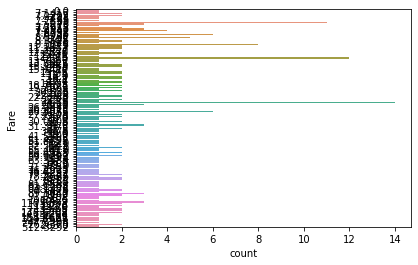

In [931]:
sns.countplot(data = GD1_survived, y="Fare")

In [932]:
GD2 = pd.read_csv('train.csv', skiprows=595)

GD2_sample = GD2.loc[:, ['Survived', 'Age']]
idx_num = GD2_sample[GD2_sample['Survived'] == 0].index
GD2_survived = GD2_sample.drop(idx_num)

<AxesSubplot:xlabel='count', ylabel='Age'>

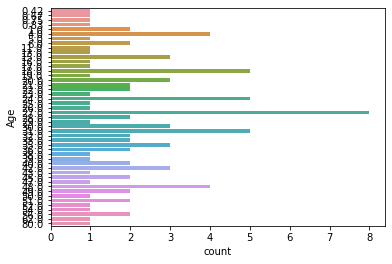

In [933]:
sns.countplot(data = GD2_survived, y="Age")

#### Age는 20 40 60 기준으로 4덩이로 나누고(20 미만, 20 <= 나이 <40 이런 식) Fare는 21.0 53.0 75.0 100.0 이렇게 5덩이로

In [934]:
binsAge = [20, 40, 60]
train_df['Age'] = np.digitize(train_df['Age'], binsAge )
test_df['Age'] = np.digitize(test_df['Age'], binsAge )

In [935]:
#print(train_df['Age'].head(38))

In [936]:
binsFare = [21.0, 53.0, 75.0, 100.0]
train_df['Fare'] = np.digitize(train_df['Fare'], binsFare )
test_df['Fare'] = np.digitize(test_df['Fare'], binsFare )


In [937]:
#print(train_df['Fare'].head(38))

#### 여기가 One Hot Encoding. 시도는 해 보았지만 결과가 좋지 않아 배제

In [938]:
"""

#train_df 재정비

OHE.fit(train_df[['Age']])
train_tmpAge = pd.DataFrame( OHE.transform(train_df[['Age']]), columns=['Age_Jr', 'Age_Young', 'Age_Middle', 'Age_Senior'])
OHE.fit(train_df[['Fare']])
train_tmpFare = pd.DataFrame( OHE.transform(train_df[['Fare']]), columns=['Fare_1', 'Fare_2', 'Fare_3', 'Fare_4', 'Fare_5'])

train_df = train_df.drop(['Age', 'Fare'], axis=1)
train_df = pd.concat([train_df, train_tmpAge, train_tmpFare], axis=1)


#test_df  재정비

OHE.fit(test_df[['Age']])
test_tmpAge = pd.DataFrame( OHE.transform(test_df[['Age']]), columns=['Age_Jr', 'Age_Young', 'Age_Middle', 'Age_Senior'])
OHE.fit(test_df[['Fare']])
test_tmpFare = pd.DataFrame( OHE.transform(test_df[['Fare']]), columns=['Fare_1', 'Fare_2', 'Fare_3', 'Fare_4', 'Fare_5'])

test_df = test_df.drop(['Age', 'Fare'], axis=1)
test_df = pd.concat([test_df, test_tmpAge, test_tmpFare], axis=1)


combine=[train_df, test_df]

"""

"\n\n#train_df 재정비\n\nOHE.fit(train_df[['Age']])\ntrain_tmpAge = pd.DataFrame( OHE.transform(train_df[['Age']]), columns=['Age_Jr', 'Age_Young', 'Age_Middle', 'Age_Senior'])\nOHE.fit(train_df[['Fare']])\ntrain_tmpFare = pd.DataFrame( OHE.transform(train_df[['Fare']]), columns=['Fare_1', 'Fare_2', 'Fare_3', 'Fare_4', 'Fare_5'])\n\ntrain_df = train_df.drop(['Age', 'Fare'], axis=1)\ntrain_df = pd.concat([train_df, train_tmpAge, train_tmpFare], axis=1)\n\n\n#test_df  재정비\n\nOHE.fit(test_df[['Age']])\ntest_tmpAge = pd.DataFrame( OHE.transform(test_df[['Age']]), columns=['Age_Jr', 'Age_Young', 'Age_Middle', 'Age_Senior'])\nOHE.fit(test_df[['Fare']])\ntest_tmpFare = pd.DataFrame( OHE.transform(test_df[['Fare']]), columns=['Fare_1', 'Fare_2', 'Fare_3', 'Fare_4', 'Fare_5'])\n\ntest_df = test_df.drop(['Age', 'Fare'], axis=1)\ntest_df = pd.concat([test_df, test_tmpAge, test_tmpFare], axis=1)\n\n\ncombine=[train_df, test_df]\n\n"

In [939]:
print(train_df.head(30))

    Survived  Pclass  Age  SibSp  Parch  Fare  Sex_M  Sex_F  Embarked_NaN  \
0          0       3    1      1      0     0    1.0    0.0           0.0   
1          1       1    1      1      0     2    0.0    1.0           0.0   
2          1       3    1      0      0     0    0.0    1.0           0.0   
3          1       1    1      1      0     2    0.0    1.0           0.0   
4          0       3    1      0      0     0    1.0    0.0           0.0   
5          0       3    1      0      0     0    1.0    0.0           0.0   
6          0       1    2      0      0     1    1.0    0.0           0.0   
7          0       3    0      3      1     1    1.0    0.0           0.0   
8          1       3    1      0      2     0    0.0    1.0           0.0   
9          1       2    0      1      0     1    0.0    1.0           0.0   
10         1       3    0      1      1     0    0.0    1.0           0.0   
11         1       1    2      0      0     1    0.0    1.0           0.0   

-> 마지막으로 'Embarked_NaN'이 1로 되어있는 row들을 날린 후, 원래 존재하지 않았어야 했던 'Embarked_NaN'도 날려버림으로써 pre-processing 완료

In [940]:
train_df = train_df[train_df['Embarked_NaN'] == 0 ]
test_df = test_df[test_df['Embarked_NaN'] == 0 ]

In [941]:
train_df = train_df.drop(['Embarked_NaN'], axis=1)
test_df = test_df.drop(['Embarked_NaN'], axis=1)
combine=[train_df, test_df]

In [942]:
print(train_df.head(30))

    Survived  Pclass  Age  SibSp  Parch  Fare  Sex_M  Sex_F  Embarked_S  \
0          0       3    1      1      0     0    1.0    0.0         1.0   
1          1       1    1      1      0     2    0.0    1.0         0.0   
2          1       3    1      0      0     0    0.0    1.0         1.0   
3          1       1    1      1      0     2    0.0    1.0         1.0   
4          0       3    1      0      0     0    1.0    0.0         1.0   
5          0       3    1      0      0     0    1.0    0.0         0.0   
6          0       1    2      0      0     1    1.0    0.0         1.0   
7          0       3    0      3      1     1    1.0    0.0         1.0   
8          1       3    1      0      2     0    0.0    1.0         1.0   
9          1       2    0      1      0     1    0.0    1.0         0.0   
10         1       3    0      1      1     0    0.0    1.0         1.0   
11         1       1    2      0      0     1    0.0    1.0         1.0   
12         0       3    1

## 3. Machine Learning Models: scikit-learn을 이용해 후술할 세 가지 machine learning model를 구현하고 성능을 평가하세요.

#### 데이터 준비 단계

여기서 .copy()를 쓰는 것은 c에서 int a = c; 와 비슷하고  그냥 담는 것은 int* a = &c와 비슷한 느낌. 

In [943]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]

X_test = test_df.drop("Survived", axis=1).copy()
Y_test = test_df["Survived"].copy()
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape 

((593, 10), (593,), (296, 10), (296,))

## 3-1 K-Nearest Neighbors(KNN): K(이웃)의 개수를 [1~5]까지 변화시키면서 test data에서 결과가 어떻게 변하는지 분석하세요

#### K가 1개

In [944]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
Accuracy_knn = round(knn.score(X_train, Y_train) * 100, 2)

In [945]:
Accuracy_knn

82.29

In [946]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       189
           1       0.65      0.61      0.63       107

    accuracy                           0.74       296
   macro avg       0.72      0.71      0.71       296
weighted avg       0.74      0.74      0.74       296



#### K가 2개

In [947]:
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
Accuracy_knn = round(knn.score(X_train, Y_train) * 100, 2)

In [948]:
Accuracy_knn

81.96

In [949]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.76      0.96      0.85       189
           1       0.87      0.45      0.59       107

    accuracy                           0.78       296
   macro avg       0.81      0.71      0.72       296
weighted avg       0.80      0.78      0.75       296



#### K가 3개

In [950]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
Accuracy_knn = round(knn.score(X_train, Y_train) * 100, 2)

In [951]:
Accuracy_knn

84.15

In [952]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       189
           1       0.79      0.64      0.71       107

    accuracy                           0.81       296
   macro avg       0.81      0.77      0.79       296
weighted avg       0.81      0.81      0.81       296



#### K가 4개

In [953]:
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
Accuracy_knn = round(knn.score(X_train, Y_train) * 100, 2)

In [954]:
Accuracy_knn

82.8

In [955]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85       189
           1       0.82      0.52      0.64       107

    accuracy                           0.79       296
   macro avg       0.80      0.73      0.74       296
weighted avg       0.79      0.79      0.77       296



#### K가 5개

In [956]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
Accuracy_knn = round(knn.score(X_train, Y_train) * 100, 2)

In [957]:
Accuracy_knn

82.97

In [958]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       189
           1       0.82      0.64      0.72       107

    accuracy                           0.82       296
   macro avg       0.82      0.78      0.80       296
weighted avg       0.82      0.82      0.82       296



## 3-2 Logistic Regression: Iteration 횟수를 0-100 범위에서 20씩 변화시키면서 test data에서 결과가 어떻게 변하는지 분석하세요. Iteration 횟수를 100으로 고정한 후 regularization term(scikit-learn에서는 C)를 0-5의 범위에서 1씩 변화시키면서 test data에서 결과가 어떻게 변하는지 분석하세요.

### Iteration 바꾸기

#### Iter : 0

In [959]:
logreg = LogisticRegression(max_iter=0).fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
Accuracy_logreg = round(logreg.score(X_train, Y_train) * 100, 2)
Accuracy_logreg

60.71

In [960]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78       189
           1       0.00      0.00      0.00       107

    accuracy                           0.64       296
   macro avg       0.32      0.50      0.39       296
weighted avg       0.41      0.64      0.50       296



#### Iter : 20

In [961]:
logreg = LogisticRegression(max_iter=20).fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
Accuracy_logreg = round(logreg.score(X_train, Y_train) * 100, 2)
Accuracy_logreg

81.11

In [962]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       189
           1       0.76      0.63      0.69       107

    accuracy                           0.79       296
   macro avg       0.78      0.76      0.77       296
weighted avg       0.79      0.79      0.79       296



#### Iter : 40

In [963]:
logreg = LogisticRegression(max_iter=40).fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
Accuracy_logreg = round(logreg.score(X_train, Y_train) * 100, 2)
Accuracy_logreg

80.94

In [964]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       189
           1       0.76      0.63      0.69       107

    accuracy                           0.79       296
   macro avg       0.78      0.76      0.77       296
weighted avg       0.79      0.79      0.79       296



#### Iter : 60

In [965]:
logreg = LogisticRegression(max_iter=60).fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
Accuracy_logreg = round(logreg.score(X_train, Y_train) * 100, 2)
Accuracy_logreg

80.94

In [966]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       189
           1       0.76      0.63      0.69       107

    accuracy                           0.79       296
   macro avg       0.78      0.76      0.77       296
weighted avg       0.79      0.79      0.79       296



#### Iter : 80

In [967]:
logreg = LogisticRegression(max_iter=80).fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
Accuracy_logreg = round(logreg.score(X_train, Y_train) * 100, 2)
Accuracy_logreg

80.94

In [968]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       189
           1       0.76      0.63      0.69       107

    accuracy                           0.79       296
   macro avg       0.78      0.76      0.77       296
weighted avg       0.79      0.79      0.79       296



#### Iter: 100

In [969]:
logreg = LogisticRegression(max_iter=100).fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
Accuracy_logreg = round(logreg.score(X_train, Y_train) * 100, 2)
Accuracy_logreg

80.94

In [970]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       189
           1       0.76      0.63      0.69       107

    accuracy                           0.79       296
   macro avg       0.78      0.76      0.77       296
weighted avg       0.79      0.79      0.79       296



### Regularization term 바꾸기

#### C : 0

In [971]:
logreg = LogisticRegression(max_iter=100, C=0 ).fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
Accuracy_logreg = round(logreg.score(X_train, Y_train) * 100, 2)
Accuracy_logreg

ZeroDivisionError: float division by zero

In [972]:
#print(classification_report(Y_test, Y_pred))

#### C : 1

In [973]:
logreg = LogisticRegression(max_iter=100, C=1 ).fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
Accuracy_logreg = round(logreg.score(X_train, Y_train) * 100, 2)
Accuracy_logreg

80.94

In [974]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       189
           1       0.76      0.63      0.69       107

    accuracy                           0.79       296
   macro avg       0.78      0.76      0.77       296
weighted avg       0.79      0.79      0.79       296



#### C : 2

In [975]:
logreg = LogisticRegression(max_iter=100, C=2 ).fit(X_train, Y_train)
Y_pred2 = logreg.predict(X_test)
Accuracy_logreg = round(logreg.score(X_train, Y_train) * 100, 2)
Accuracy_logreg

81.11

In [976]:
print(classification_report(Y_test, Y_pred2))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       189
           1       0.76      0.63      0.69       107

    accuracy                           0.79       296
   macro avg       0.78      0.76      0.77       296
weighted avg       0.79      0.79      0.79       296



#### C : 3

In [977]:
logreg = LogisticRegression(max_iter=100, C=3 ).fit(X_train, Y_train)
Y_pred3 = logreg.predict(X_test)
Accuracy_logreg = round(logreg.score(X_train, Y_train) * 100, 2)
Accuracy_logreg

81.11

In [978]:
print(classification_report(Y_test, Y_pred3))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       189
           1       0.77      0.63      0.69       107

    accuracy                           0.80       296
   macro avg       0.79      0.76      0.77       296
weighted avg       0.79      0.80      0.79       296



#### C : 4

In [979]:
logreg = LogisticRegression(max_iter=100, C=4 ).fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
Accuracy_logreg = round(logreg.score(X_train, Y_train) * 100, 2)
Accuracy_logreg

80.94

In [980]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       189
           1       0.77      0.63      0.69       107

    accuracy                           0.80       296
   macro avg       0.79      0.76      0.77       296
weighted avg       0.79      0.80      0.79       296



#### C : 5

In [981]:
logreg = LogisticRegression(max_iter=100, C=5 ).fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
Accuracy_logreg = round(logreg.score(X_train, Y_train) * 100, 2)
Accuracy_logreg

80.94

In [982]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       189
           1       0.77      0.63      0.69       107

    accuracy                           0.80       296
   macro avg       0.79      0.76      0.77       296
weighted avg       0.79      0.80      0.79       296



## 3-3 Decision Tree: Information Gain을 통해 test data에서 결과가 어떻게 나오는지 분석하세요. 또한 적절한 tool을 이용하여 각 depth에서의 조건과 gain값을 알 수 있도록 tree를 시각화 하세요.

In [983]:
decision_tree = DecisionTreeClassifier(criterion ='entropy')
decision_tree = decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
Accuracy_decision_tree = round(decision_tree.score(X_train, Y_train) * 100 , 2)
Accuracy_decision_tree

87.35

In [984]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       189
           1       0.72      0.64      0.68       107

    accuracy                           0.78       296
   macro avg       0.77      0.75      0.76       296
weighted avg       0.78      0.78      0.78       296



In [985]:
print(train_df.head())

   Survived  Pclass  Age  SibSp  Parch  Fare  Sex_M  Sex_F  Embarked_S  \
0         0       3    1      1      0     0    1.0    0.0         1.0   
1         1       1    1      1      0     2    0.0    1.0         0.0   
2         1       3    1      0      0     0    0.0    1.0         1.0   
3         1       1    1      1      0     2    0.0    1.0         1.0   
4         0       3    1      0      0     0    1.0    0.0         1.0   

   Embarked_Q  Embarked_C  
0         0.0         0.0  
1         0.0         1.0  
2         0.0         0.0  
3         0.0         0.0  
4         0.0         0.0  


### Visualiztion : 각 depth에서의 조건과 gain

In [986]:
"""

dot_data = export_graphviz(decision_tree, out_file = None, class_names=['Died', 'Survived'], 
                           feature_names=['Pclass', 'SibSp', 'Parch', 'Sex_M', 'Sex_F', 
                                          'Embarked_S', 'Embarked_Q', 'Embarked_C', 
                                          'Age_Jr', 'Age_Young', 'Age_Middle', 'Age_Senior', 
                                          'Fare_1' , 'Fare_2' , 'Fare_3' , 'Fare_4', 'Fare_5'], 
                                          filled = True, special_characters = True, rounded=True  )

graphviz.Source(dot_data)

"""

"\n\ndot_data = export_graphviz(decision_tree, out_file = None, class_names=['Died', 'Survived'], \n                           feature_names=['Pclass', 'SibSp', 'Parch', 'Sex_M', 'Sex_F', \n                                          'Embarked_S', 'Embarked_Q', 'Embarked_C', \n                                          'Age_Jr', 'Age_Young', 'Age_Middle', 'Age_Senior', \n                                          'Fare_1' , 'Fare_2' , 'Fare_3' , 'Fare_4', 'Fare_5'], \n                                          filled = True, special_characters = True, rounded=True  )\n\ngraphviz.Source(dot_data)\n\n"

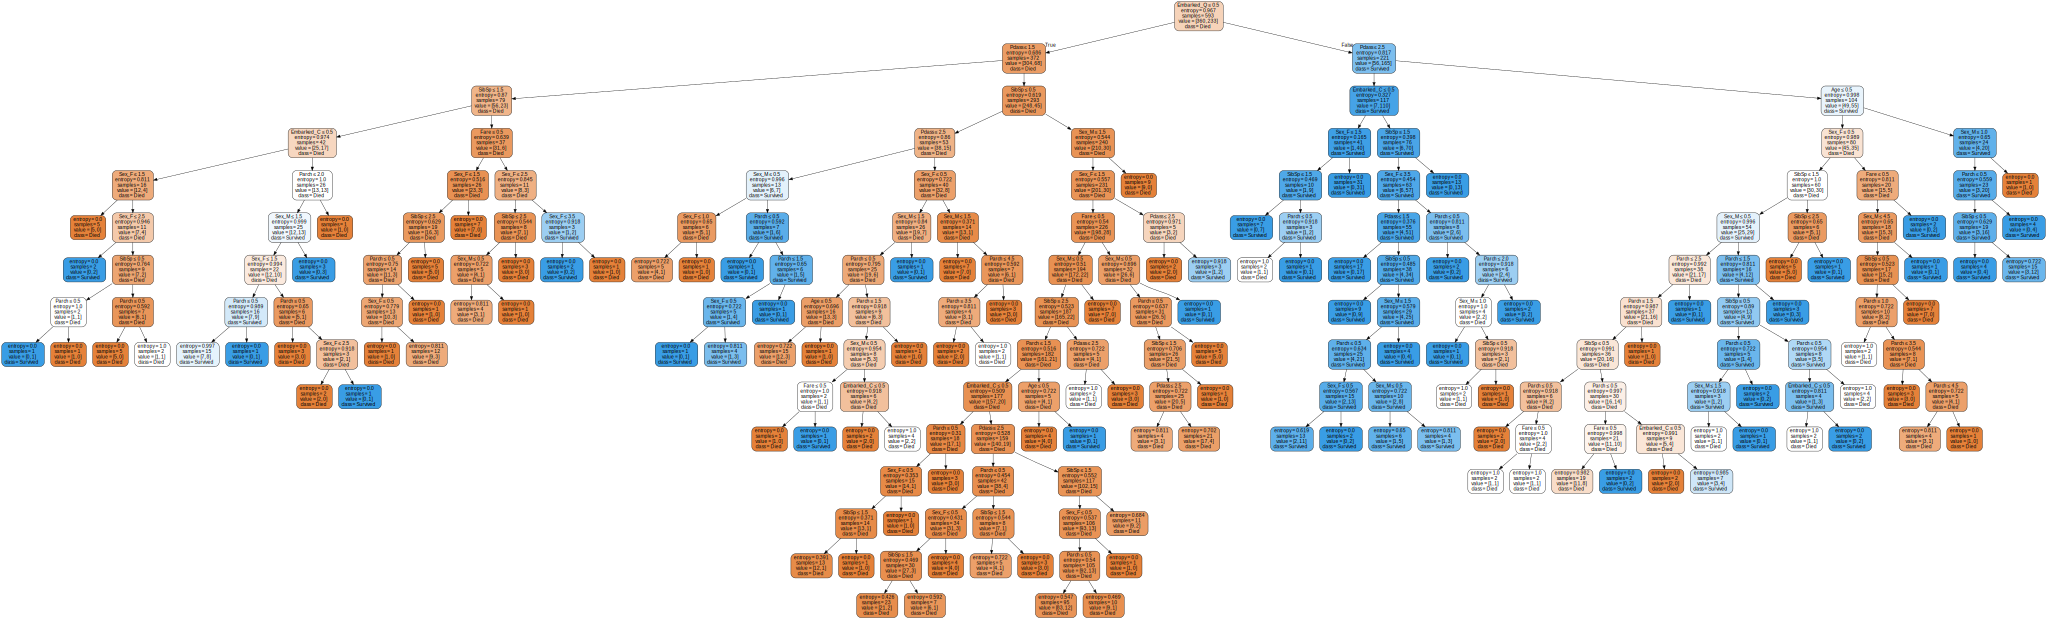

In [987]:
dot_data = export_graphviz(decision_tree, 
                           out_file = None, class_names=['Died', 'Survived'], 
                           feature_names=['Pclass', 'SibSp', 'Parch', 'Sex_M', 
                                          'Sex_F', 'Embarked_S', 'Embarked_Q', 
                                          'Embarked_C','Age','Fare'],  
                           filled = True, special_characters = True, rounded=True)

to_png = graphviz.Source(dot_data)
to_png.format = 'png'
to_png.render(filename='tree', directory='./', cleanup=True)

graphviz.Source(dot_data)

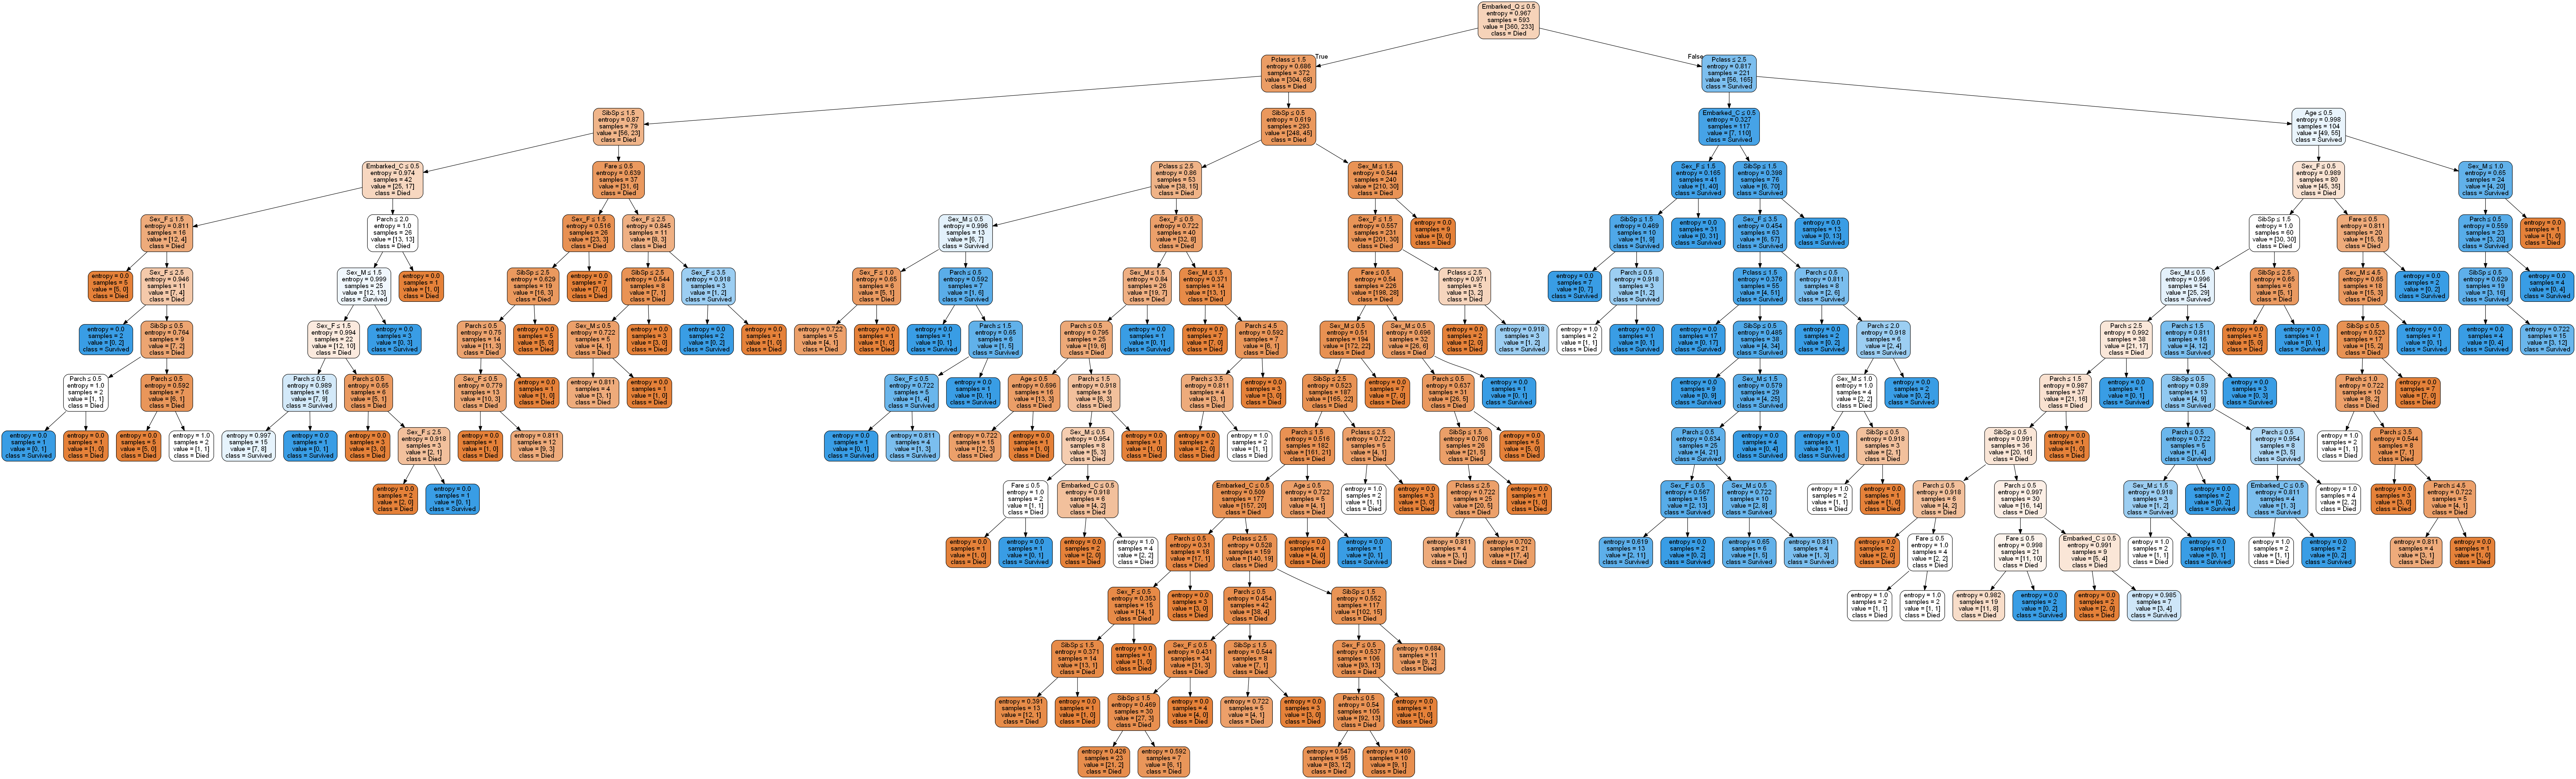

In [988]:
Image("tree.png")

## 3-3-1 Bagging with Decision Tree: Decision Tree 기반으로 Bagging 기법을 이용하여 bag의 수에 따라 test data에서 결과가 어떻게 변하는지 decision tree와 비교하여 분석하세요. Bag의 수는 [1~5]에서 1씩 변화시키세요

#### Bag : 1  - 실행할 때마다 변하네. 하지만 Bag가 높을수록 평균적으로 accuracy가 더 높게 나오는 것 같음

In [989]:
bag_tree = BaggingClassifier(DecisionTreeClassifier(criterion ='entropy'), 
                             n_estimators=1)
bag_tree = bag_tree.fit(X_train, Y_train)
Y_pred = bag_tree.predict(X_test)
Accuracy_bag_tree = round(bag_tree.score(X_train, Y_train) * 100 , 2)
Accuracy_bag_tree                        

84.65

In [990]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       189
           1       0.76      0.66      0.71       107

    accuracy                           0.80       296
   macro avg       0.79      0.77      0.78       296
weighted avg       0.80      0.80      0.80       296



#### Bag : 2

In [991]:
bag_tree = BaggingClassifier(DecisionTreeClassifier(criterion ='entropy'),
                             n_estimators=2)
bag_tree = bag_tree.fit(X_train, Y_train)
Y_pred = bag_tree.predict(X_test)
Accuracy_bag_tree = round(bag_tree.score(X_train, Y_train) * 100 , 2)
Accuracy_bag_tree   

83.31

In [992]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       189
           1       0.74      0.62      0.67       107

    accuracy                           0.78       296
   macro avg       0.77      0.75      0.76       296
weighted avg       0.78      0.78      0.78       296



#### Bag : 3

In [993]:
bag_tree = BaggingClassifier(DecisionTreeClassifier(criterion ='entropy'), 
                             n_estimators=3)
bag_tree = bag_tree.fit(X_train, Y_train)
Y_pred = bag_tree.predict(X_test)
Accuracy_bag_tree = round(bag_tree.score(X_train, Y_train) * 100 , 2)
Accuracy_bag_tree   

86.51

In [994]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       189
           1       0.76      0.73      0.75       107

    accuracy                           0.82       296
   macro avg       0.81      0.80      0.80       296
weighted avg       0.82      0.82      0.82       296



#### Bag : 4

In [995]:
bag_tree = BaggingClassifier(DecisionTreeClassifier(criterion ='entropy'), 
                             n_estimators=4)
bag_tree = bag_tree.fit(X_train, Y_train)
Y_pred = bag_tree.predict(X_test)
Accuracy_bag_tree = round(bag_tree.score(X_train, Y_train) * 100 , 2)
Accuracy_bag_tree   

85.83

In [996]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       189
           1       0.80      0.65      0.72       107

    accuracy                           0.81       296
   macro avg       0.81      0.78      0.79       296
weighted avg       0.81      0.81      0.81       296



#### Bag : 5

In [997]:
bag_tree = BaggingClassifier(DecisionTreeClassifier(criterion ='entropy'), 
                             n_estimators=5)
bag_tree = bag_tree.fit(X_train, Y_train)
Y_pred = bag_tree.predict(X_test)
Accuracy_bag_tree = round(bag_tree.score(X_train, Y_train) * 100 , 2)
Accuracy_bag_tree   

85.83

In [998]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       189
           1       0.74      0.69      0.71       107

    accuracy                           0.80       296
   macro avg       0.79      0.78      0.78       296
weighted avg       0.80      0.80      0.80       296



# fin